In [1]:
import numpy as np
import cv2
import skimage
from scipy import ndimage
from skimage import exposure  # skimage's exposure module.
from skimage import io  # skimage's I/O submodule.
from skimage import filters
from skimage import morphology  # skimage's morphological submodules.
from skimage import measure  # skimage's measure submodule.
from skimage import feature  # skimage's feature submodule.
from skimage import segmentation
from skimage.segmentation import mark_boundaries

import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.decomposition import FastICA, PCA

In [3]:
!ls data

BK68_SpotsOnDapi.tif


In [4]:
fn = 'data/BK68_SpotsOnDapi.tif'

In [5]:
img = cv2.imread(fn)[...,::-1]

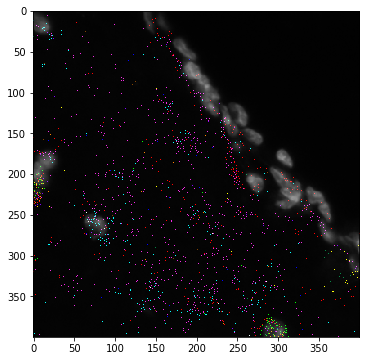

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(img[:400,:400])

In [7]:
img.shape

(1366, 1366, 3)

In [8]:
img[:3,:3,:]

array([[[13, 13, 13],
        [14, 14, 14],
        [15, 15, 15]],

       [[19, 19, 19],
        [19, 19, 19],
        [20, 20, 20]],

       [[24, 24, 24],
        [25, 25, 25],
        [24, 24, 24]]], dtype=uint8)

## step 1: Unsupervised Spectral Unmixing

attempts with ICA and RANSAC failed
- ICA: does not work for n_input < n_output
- RANSAC: predictions make no sense

In [9]:
# ica = FastICA(n_components=11, algorithm='deflation')
# S_ = ica.fit_transform(img.reshape(-1,3))  # Reconstruct signals
# A_ = ica.mixing_  # Get estimated mixing matrix

In [129]:
# from sklearn.linear_model import RANSACRegressor

# rs = RANSACRegressor(max_trials=500)
# rs.fit(vec_rgb_nonwhite[:,:1], vec_rgb_nonwhite[:,2])
# line_y_ransac = rs.predict(vec_rgb_nonwhite[:,:1])
# se = (line_y_ransac-vec_rgb_nonwhite[:,2])**2
# np.percentile(np.log10(se),10)

### flatten the image

In [137]:
vec_rgb = img.reshape(-1,3) / img.reshape(-1,3).sum(1).reshape(-1,1)*3
vec_rgb.shape

/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(1865956, 3)

In [22]:
non_black_mask = ~np.isnan(vec_rgb).any(1)
non_white_mask = ~(vec_rgb==1.).all(1)
vec_rgb_nonwhite = vec_rgb[non_white_mask & non_black_mask]
sum(non_white_mask)

29245

### convert to HSV space

In [ ]:
img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

In [139]:
vec_hsv = img_hsv.reshape(-1,3)
vec_hsv.shape

(1865956, 3)

In [146]:
df_hsv = pd.DataFrame(vec_hsv, columns=['h', 's', 'v'])

In [153]:
df_hsv.groupby('h').count().sort_values('s', ascending=False)[:15]

,s,v
h,,
0,1845906,1845906
152,10700,10700
90,2750,2750
15,1457,1457
120,955,955
150,946,946
30,656,656
75,591,591
135,551,551


In [156]:
df_hsv[df_hsv['s']>220].groupby('h').count().sort_values('s', ascending=False)[:15]

,s,v
h,,
0,8326,8326
90,2422,2422
15,1253,1253
120,891,891
30,561,561
135,551,551
75,456,456
60,421,421
136,120,120


Text(0.5, 0, 'saturation')

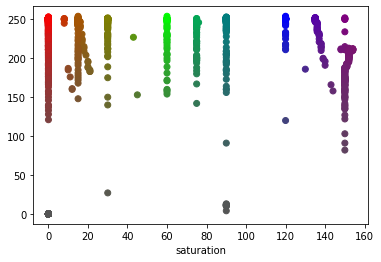

In [144]:
n = 10
plt.scatter(vec_hsv[::n,0], vec_hsv[::n,1],
           c=vec_rgb[::n,:]/3)
plt.xlabel('hue')
plt.xlabel('saturation')

### observation:
some colors are 'pure', but some mix with others (eg. purple, orange)

Text(0.5, 0, 'value')

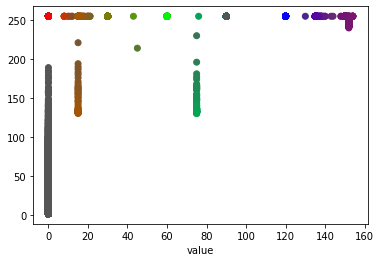

In [145]:
n = 10
plt.scatter(vec_hsv[::n,0], vec_hsv[::n,2],
           c=vec_rgb[::n,:]/3)
plt.xlabel('hue')
plt.xlabel('value')

### plot R vs G channels 

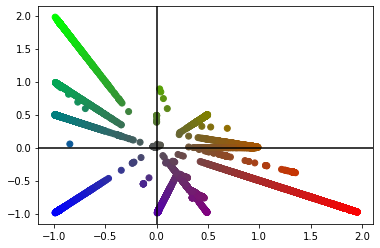

In [131]:
n = 50000
plt.scatter(vec_rgb_nonwhite[:n,0]-1, vec_rgb_nonwhite[:n,1]-1,
            c=(vec_rgb_nonwhite[:n,:]/3).tolist())
plt.axvline(0, c='k')
plt.axhline(0, c='k')
pass

### observation: 
lines converge with intercept (1,1)
**hack**: subracting 1 will provide a constant number (slope) for each hue line

In [23]:
ratio1 = (vec_rgb[:,0]-1)/(vec_rgb[:,1]-1)
ratio2 = (vec_rgb[:,0]-1)/(vec_rgb[:,2]-1)
ratio3 = (vec_rgb[:,1]-1)/(vec_rgb[:,2]-1)
mask = (~(np.isinf(ratio1)|np.isinf(ratio2)|np.isinf(ratio3)))&non_white_mask&non_black_mask
ratio1 = ratio1[mask]
ratio2 = ratio2[mask]
ratio3 = ratio3[mask]
len(mask), sum(mask)

/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/imagexd/lib/python3.7/site-packages/ipykernel

(1865956, 27562)

In [25]:
# # np.isinf(ratio1).any()
slopes = {kk:vv for kk,vv in Counter(zip(np.round(ratio1,3),
                                         np.round(ratio2,3),
                                         np.round(ratio3,3)
                                        )).items() if vv>50}
len(slopes)

9

In [26]:
slope_diffs = {}
for kk, sl in enumerate(slopes):
    kk+=1
    dd = np.stack([ratio1, ratio2, ratio3]).T - np.asarray(sl)
    slope_diffs[kk] = (dd**2).sum(1)

### reconstruct integer-valued RNA map

In [36]:
labels = np.zeros_like(mask, dtype='uint8')
print(labels.shape)
labels[mask] = pd.DataFrame(slope_diffs).idxmin(1).values
labels = labels.reshape(img.shape[:2])
labels.shape

(1865956,)


(1366, 1366)

In [34]:
np.bincount(labels)

array([1838394,    1582,   10899,   12050,    1766,     444,     264,
           189,     198,     170])

### construct multi-channel RNA map

In [45]:
label_oh = np.zeros(labels.shape+(1+len(slopes,),))
for kk, sl in enumerate(slopes):
    label_oh[...,kk+1] = labels == kk+1
label_oh.shape

(1366, 1366, 10)

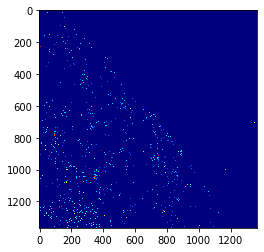

In [31]:
plt.imshow(labels.reshape(img.shape[:2]), cmap='jet')

### blur

In [53]:
sigma = 20
plane_denoised = filters.gaussian(label_oh,
                                  multichannel=True,
                                  sigma=sigma)

In [17]:
plane_denoised.max()

0.12178951792148333

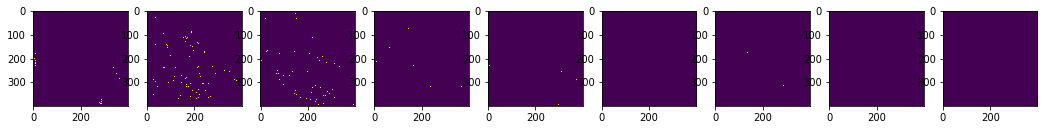

In [115]:
fig, axs = plt.subplots(1,len(slopes),figsize=(18,4))
for ch in range(1, len(slopes)+1):
    axs[ch-1].imshow(label_oh[:400,:400,ch])

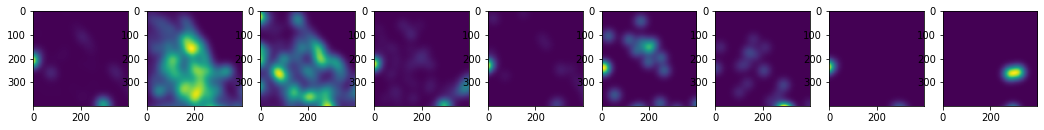

In [68]:
fig, axs = plt.subplots(1,len(slopes),figsize=(18,4))
for ch in range(1, len(slopes)+1):
    axs[ch-1].imshow(plane_denoised[:400,:400,ch]/plane_denoised[...,ch].max())

## Super-pixel Segmentation

In [125]:
#felzenszwalb, slic, quickshift, watershed
segments_fz = segmentation.felzenszwalb(label_oh, scale=50, sigma=8., min_size=5)

In [76]:
np.bincount(segments_fz.ravel())

array([1852568,    1512,     279,     589,     730,     516,     774,
            66,    5207,    1115,      67,    1053,     425,     184,
           728,     143])

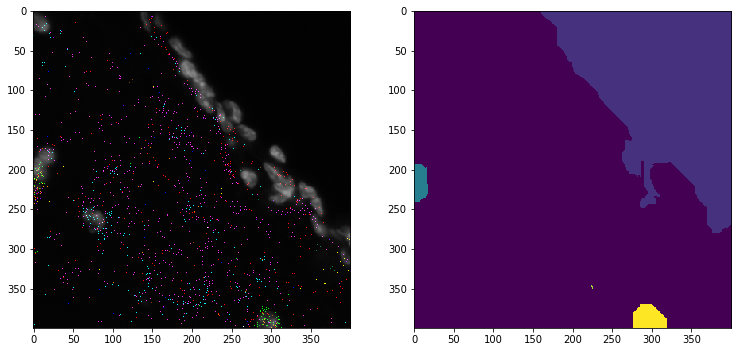

In [126]:
fig, axs = plt.subplots(1,2,figsize=(12.5,6))
axs[0].imshow(img[:400,:400,:])
axs[1].imshow(segments_fz[:400,:400])

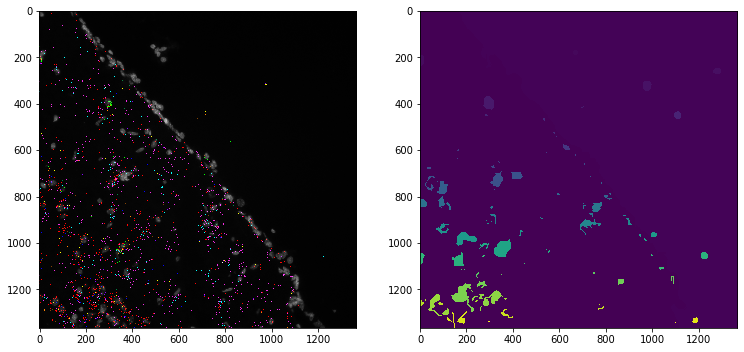

In [127]:
fig, axs = plt.subplots(1,2,figsize=(12.5,6))
axs[0].imshow(img)
axs[1].imshow(segments_fz)